In [ ]:
pip install neo4j python-dotenv stringdb fastcluster

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 286.8/286.8 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.0/194.0 kB 12.6 MB/s eta 0:00:00


In [ ]:
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SelectKBest, chi2, RFE
from sklearn.metrics import f1_score, balanced_accuracy_score, make_scorer
from sklearn.svm import SVC
from sklearn import datasets
from google.colab import drive
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colormaps
from matplotlib.colors import LinearSegmentedColormap
from colour import Color
from sklearn.manifold import TSNE

In [ ]:
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
genes_csv = pd.read_csv("/content/drive/MyDrive/genes.csv", delimiter=",", decimal=',', header=None)

In [ ]:
df = genes_csv.drop(axis=1, labels=[genes_csv.shape[1] - 1]) # Removing Mean Average Deviation values
df = df.transpose()
df.iloc[0, 0] = "prognostic"
df.iloc[0, 1] = "subtype"
df.columns = df.iloc[0, :]
df = df.drop(index=0)
df.to_csv("/content/drive/MyDrive/genes_transformed.csv", index=False)

df

,prognostic,subtype,RN7SL1,RPPH1,RN7SL2,HBB,ENSG00000277027,ENSG00000222328,ATP8,COX1,...,DNAJC5,SKIC3,CCDC93,PNPLA8,SH2D4B,SCAND1,ARHGAP15,ISG20L2,MDM1,ZNF687
1,POOR,BCRABL1,1485.58,22.11,2669.77,3295.73,21.2,58.2,28287.83,6626.21,...,13.94,42.8,28.68,10.01,1.55,32.45,68.77,14.28,29.51,24.02
2,POOR,BCRABL1,226.93,42,313.05,1.14,14.03,57.63,8997.56,5054.53,...,18.57,22.86,55.43,85.51,55.92,21.46,41.65,13.5,38.23,26.51
3,POOR,BCRABL1,40368.77,47211.57,24591.58,3884.15,35022.15,15009.22,35.41,645.89,...,11.59,17.32,8.49,8.62,6.45,9.89,27.79,3.97,10.7,6.63
4,POOR,BCRABL1,80556.08,24571.67,70169.91,490.28,21913.15,13056.92,132.27,1575.16,...,6.32,16.39,10.63,11.31,0.45,11.64,67.47,3.01,7.45,7.76
5,POOR,BCRABL1,386.56,77.24,589.56,15234.36,41.53,134.96,11299.48,11759.6,...,13.34,38.26,34.92,24.67,0.53,24.83,78.21,24.4,29.7,31.64
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275,POOR,KMT2A,40735.2,49212.65,30228.39,38934.43,26563.96,26622.42,79.32,679.27,...,2.44,8.95,11.22,57.46,0.06,5.23,14.25,6.93,3.37,7.91
276,POOR,KMT2A,749.49,43.73,1246.58,1166.57,54.69,160.95,17401.1,24022.38,...,50.65,71.94,42.99,33.4,31.69,18.22,42.69,53.13,57.93,41.09
277,POOR,KMT2A,56880.77,35307.14,49784.8,553.14,26052.82,16029.38,194.51,1472.21,...,3.1,21.77,8.53,29.73,1.09,2.55,18.97,7.41,5.86,6.66
278,POOR,KMT2A,1636.31,151.65,2672.03,1487.72,133.61,77.1,11893.44,13557.86,...,53.3,66.47,30.62,29.6,2.86,22.89,51.71,57.88,59.7,42.97


In [ ]:
data = pd.read_csv("/content/drive/MyDrive/genes_transformed.csv", delimiter=",", decimal='.')

In [ ]:
def make_dataset(data, features, target):
  X = data.drop(axis=1, labels=["prognostic", "subtype", "subtype_target"], errors="ignore")
  y = data[target]
  X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
  feature_names = X.columns

  if features != None:
    kbest = SelectKBest(chi2, k=features)
    X_train = kbest.fit_transform(X_train, y_train)
    X_test = kbest.transform(X_test)
    feature_names = np.array(X.columns)[kbest.get_support(indices=False)]

  scaler = StandardScaler()
  X_train = scaler.fit_transform(X_train)
  X_test = scaler.transform(X_test)

  return X_train, y_train, X_test, y_test, feature_names

In [ ]:
def train_forest(target, data=data, features=None):
  X_train, y_train, X_test, y_test, feature_names = make_dataset(data, features, target)
  model = RandomForestClassifier(n_estimators=32, random_state=774)
  model.fit(X_train, y_train)
  score = f1_score(y_test, model.predict(X_test), average="weighted")
  print(f"Acc: {balanced_accuracy_score(y_test, model.predict(X_test))}")

  return model, score, feature_names

In [ ]:
colors = ["#00FF00", "#000000", "#FF0000"]
cmap = LinearSegmentedColormap.from_list("gene", [Color( c1 ).rgb for c1 in colors])

In [ ]:
def get_importances(importances, feature_names, top=10):
  sorted_importances = { name: importance for importance, name in sorted(zip(importances, feature_names), key=lambda x: x[0], reverse=True) }
  return pd.Series(data=sorted_importances)[:top]

In [ ]:
def plot_clustermap(cluster_data, col_colors):
  return sns.clustermap(np.log2(cluster_data, out=np.zeros_like(cluster_data), where=cluster_data != 0), col_colors=col_colors, method="ward", z_score=0, metric="euclidean", cmap=cmap, vmin=-4, vmax=4)

def plot_legend(g, subtypes, lut):
  for label in subtypes.unique():
      g.ax_col_dendrogram.bar(0, 0, color=lut[label], label=label, linewidth=0)

  g.ax_col_dendrogram.legend(title='Subtype', loc="center", ncol=5, bbox_to_anchor=(0.47, 0.8))

In [ ]:
def show_cluster(metric, top=10, features=None):
  model, score, feature_names = train_forest(metric, features=features, data=data)

  print("F1 Score:", score)
  importances = get_importances(model.feature_importances_, feature_names, top=top)
  sns.barplot(x=importances, y=importances.index, orient='h').set(xlabel='Importance', ylabel='Gene', title=f"Importância de cada gene ({metric})")

  subtypes = data["subtype"]
  palette = sns.cubehelix_palette(subtypes.unique().size, light=.9, dark=.1, reverse=True, start=1, rot=-2)
  lut = dict(zip(map(str, subtypes.unique()), palette))
  col_colors = [subtypes.map(lut), data["prognostic"].map({ "POOR": "r", "GOOD": "g" })]

  cluster_data = data.drop(axis=1, labels=["prognostic", "subtype"])[importances.index].transpose()
  g = plot_clustermap(cluster_data, col_colors=col_colors)
  plot_legend(g, subtypes, lut)

  plt.show()

Acc: 1.0
F1 Score: 1.0


/usr/local/lib/python3.10/dist-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log2
  result = func(self.values, **kwargs)


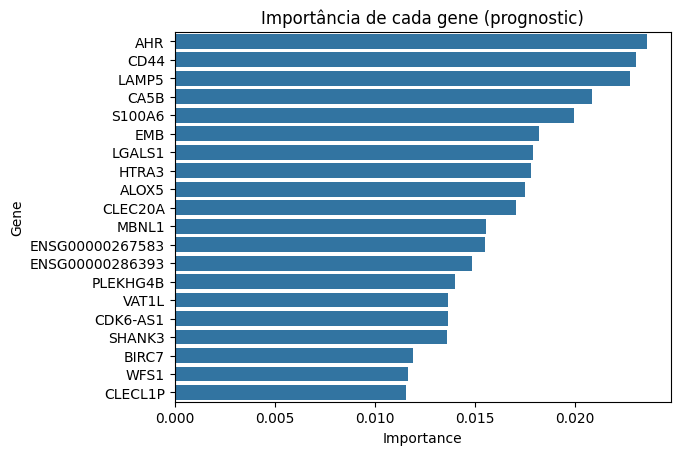

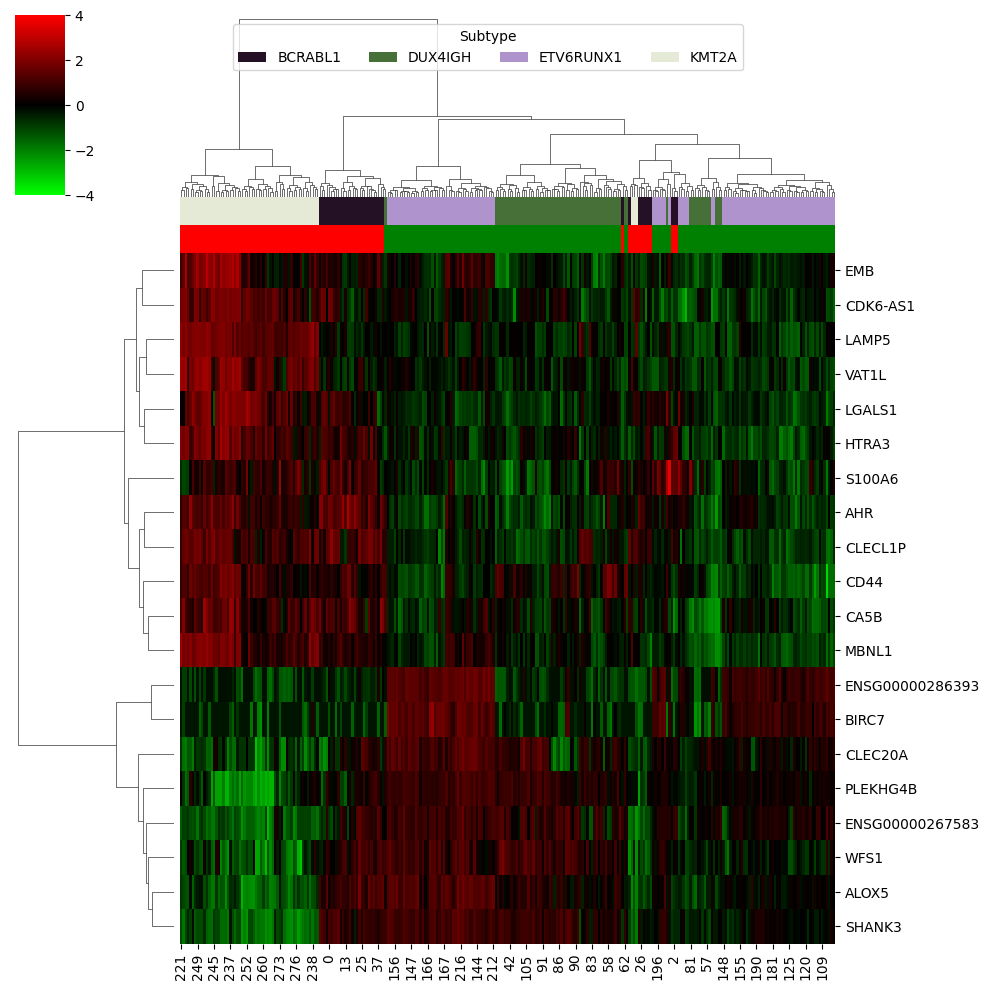

In [ ]:
show_cluster("prognostic", top=20)

Acc: 0.9635416666666666
F1 Score: 0.971416698204917


/usr/local/lib/python3.10/dist-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log2
  result = func(self.values, **kwargs)


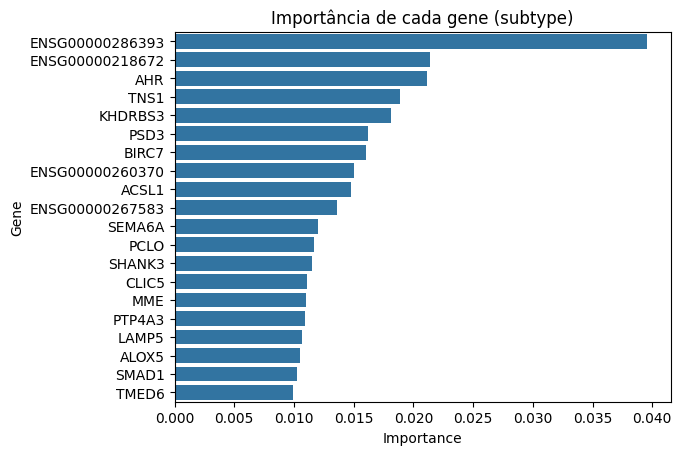

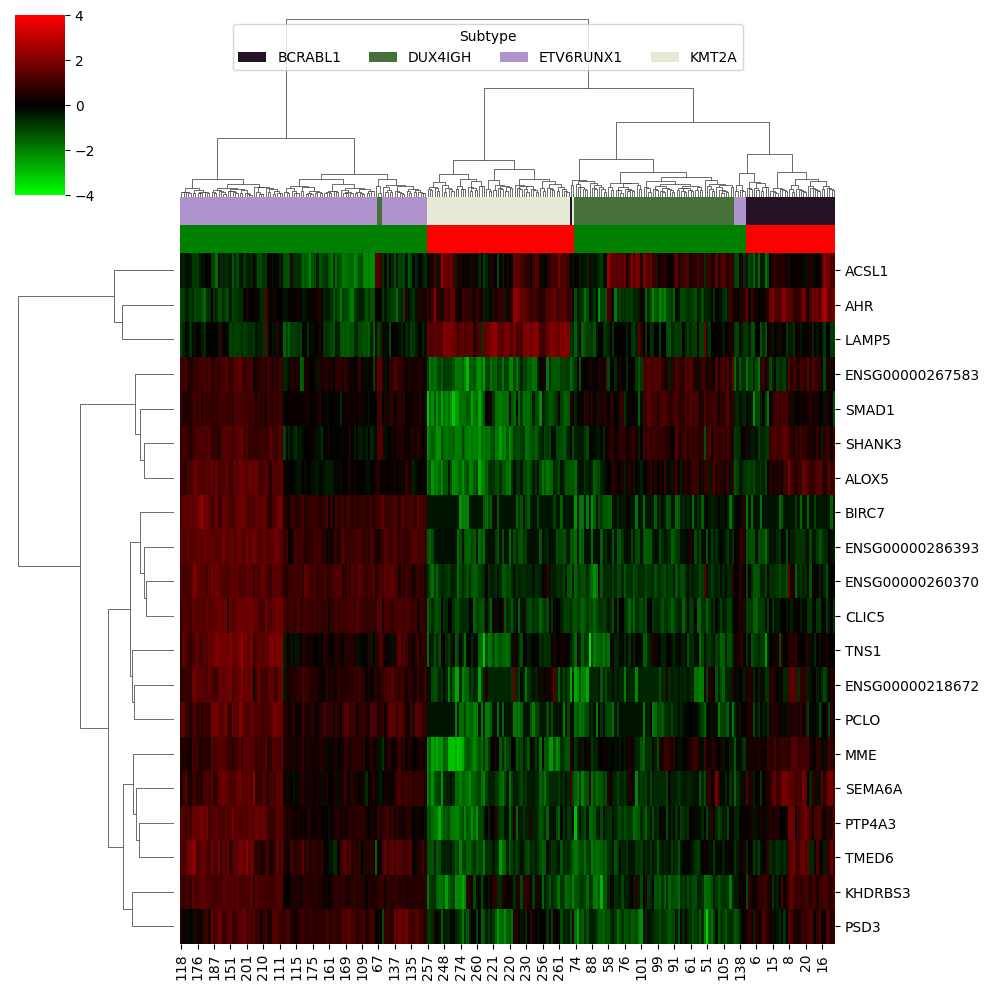

In [ ]:
show_cluster("subtype", top=20)

Acc: 0.8333333333333333
Subtype BCRABL1 - F1 Score 0.938095238095238


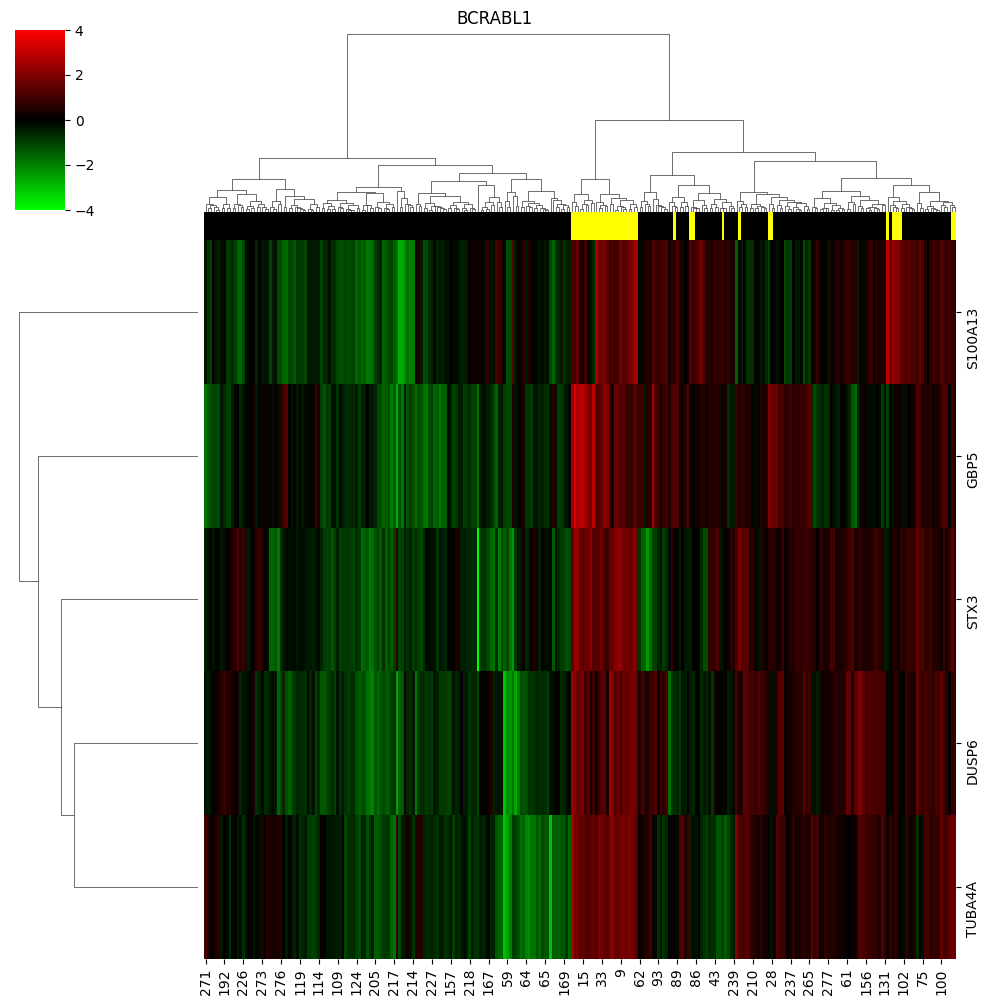

GBP5       0.023787
STX3       0.020431
DUSP6      0.019431
S100A13    0.019071
TUBA4A     0.018487
Acc: 0.96875
Subtype DUX4IGH - F1 Score 0.9855494017672177


/usr/local/lib/python3.10/dist-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log2
  result = func(self.values, **kwargs)


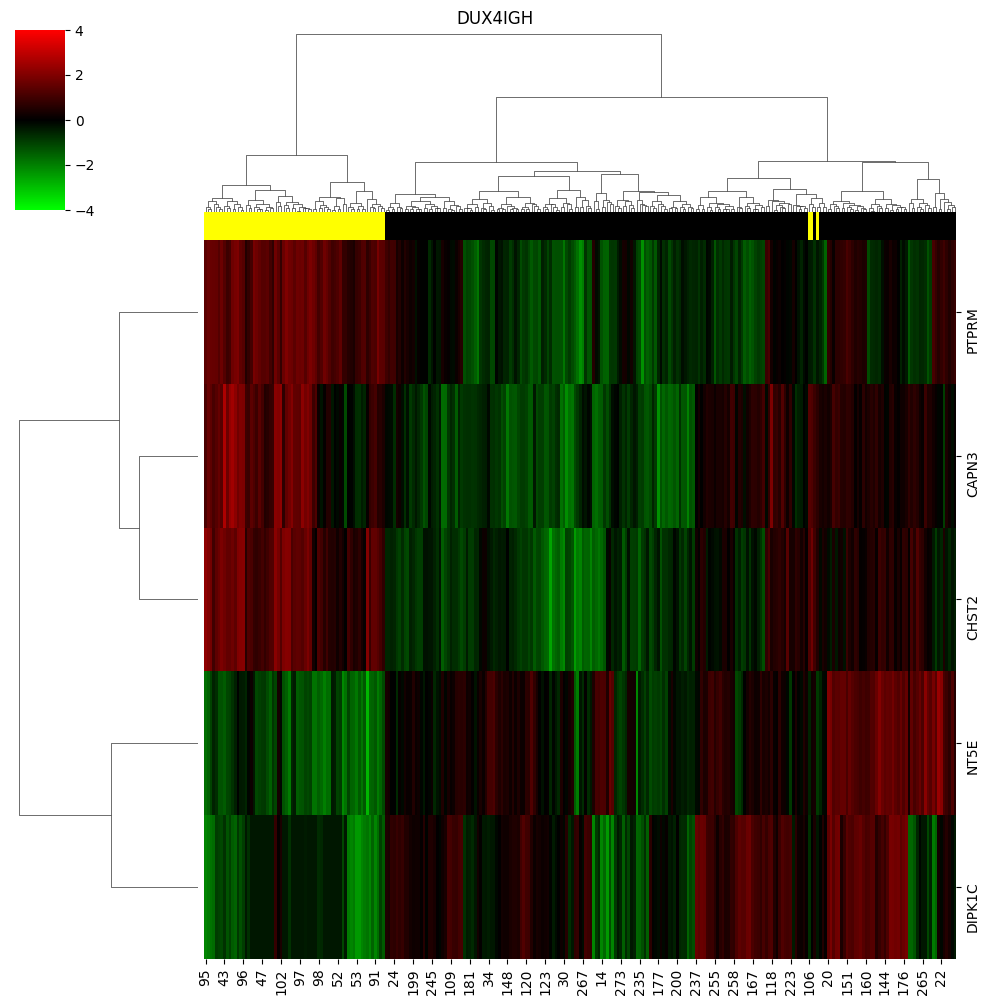

CAPN3     0.031841
NT5E      0.030872
PTPRM     0.025484
DIPK1C    0.024763
CHST2     0.020982
Acc: 1.0
Subtype ETV6RUNX1 - F1 Score 1.0


/usr/local/lib/python3.10/dist-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log2
  result = func(self.values, **kwargs)


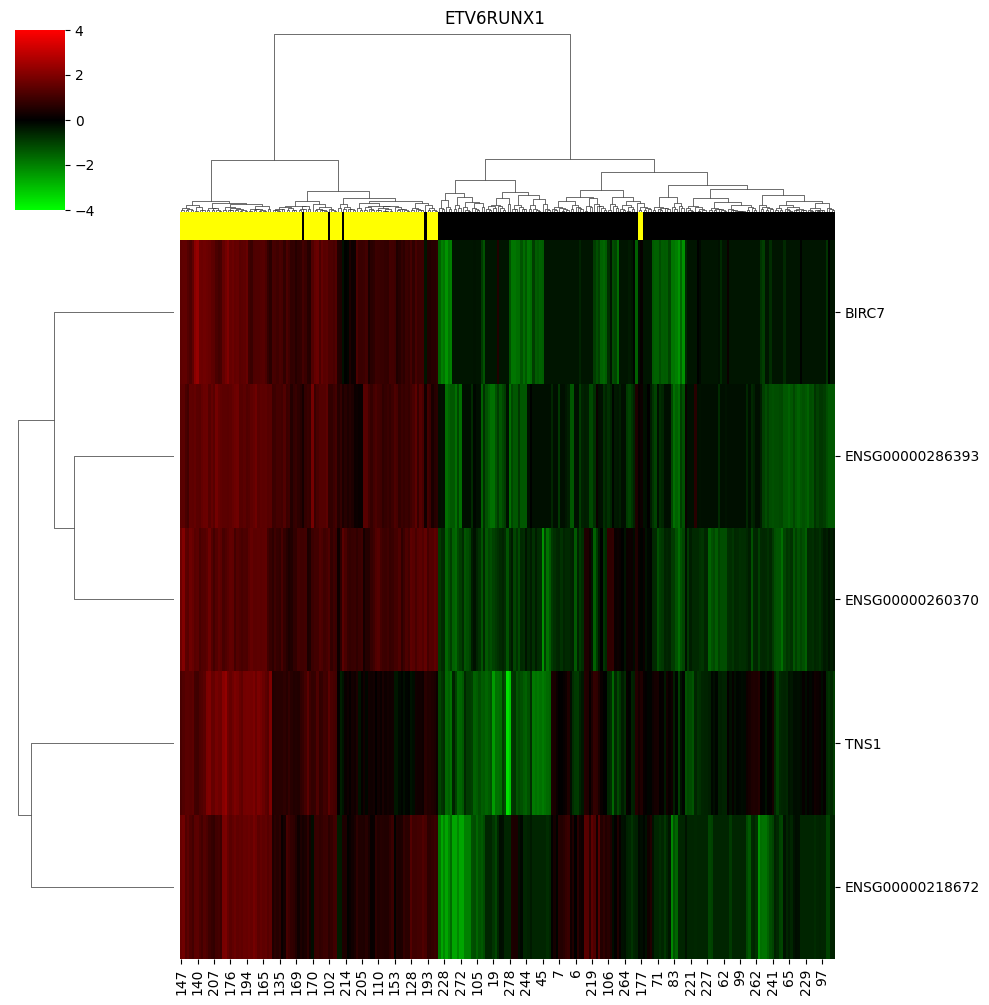

ENSG00000286393    0.041365
TNS1               0.036674
ENSG00000218672    0.033196
BIRC7              0.028849
ENSG00000260370    0.027666
Acc: 1.0
Subtype KMT2A - F1 Score 1.0


/usr/local/lib/python3.10/dist-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log2
  result = func(self.values, **kwargs)


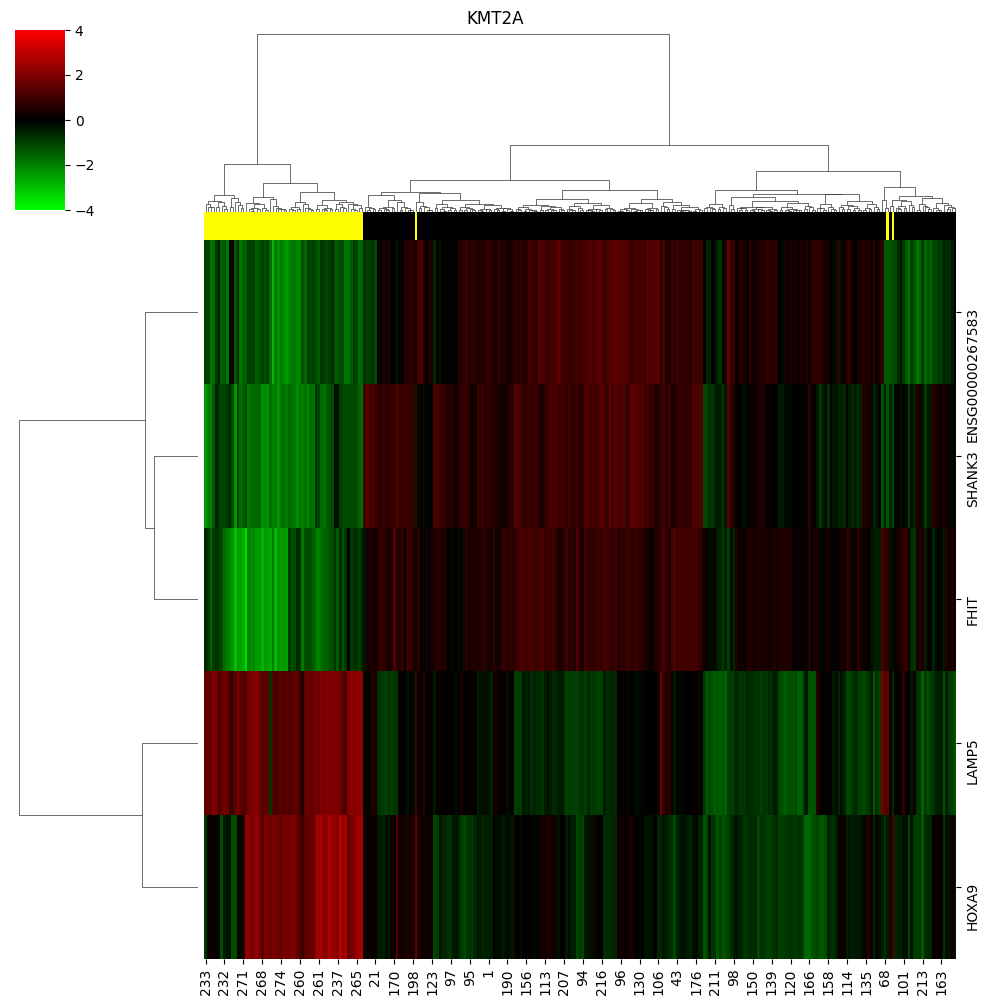

SHANK3             0.032940
LAMP5              0.031974
ENSG00000267583    0.030899
FHIT               0.028320
HOXA9              0.025563


In [ ]:
importances_by_subtype = {}
genes = set()
for subtype in data["subtype"].unique():
  targeted_data = data.copy()
  targeted_data["subtype_target"] = targeted_data["subtype"] == subtype

  model, score, feature_names = train_forest("subtype_target", data=targeted_data)
  print(f"Subtype {subtype} - F1 Score {score}")

  importances_target = get_importances(model.feature_importances_, feature_names, top=5)
  importances_by_subtype[subtype] = importances_target
  genes |= set(importances_target.index)

  cluster_data = targeted_data.drop(axis=1, labels=["prognostic", "subtype", "subtype_target"])[importances_target.index].transpose()
  col_colors = [targeted_data["subtype_target"].map({ True: "yellow", False: "black" })]

  g = plot_clustermap(cluster_data, col_colors)
  g.fig.suptitle(subtype, y=1)
  plt.show()

  print(importances_target.to_string())

important_genes = list(genes)

<Axes: title={'center': 'Importância de cada gene por subtipo One-vs-All'}, xlabel='Importance', ylabel='Gene'>

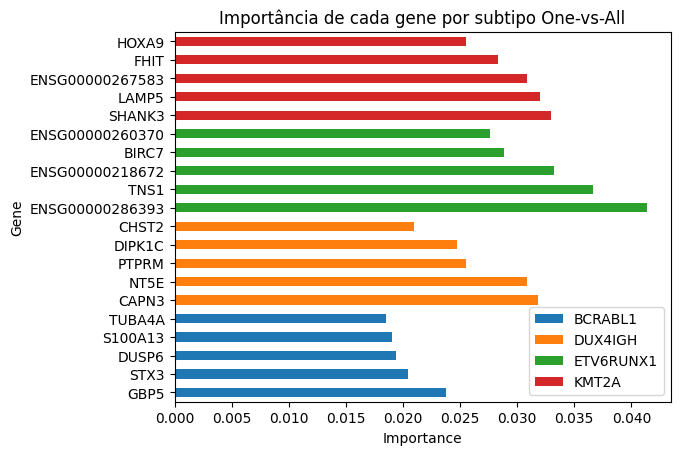

In [ ]:
one_vs_all_df = pd.concat(importances_by_subtype.values(), axis=1).fillna(0)
one_vs_all_df.columns = importances_by_subtype.keys()
one_vs_all_df.plot(kind="barh", stacked=True, xlabel='Importance', ylabel='Gene', title="Importância de cada gene por subtipo One-vs-All")

/usr/local/lib/python3.10/dist-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log2
  result = func(self.values, **kwargs)


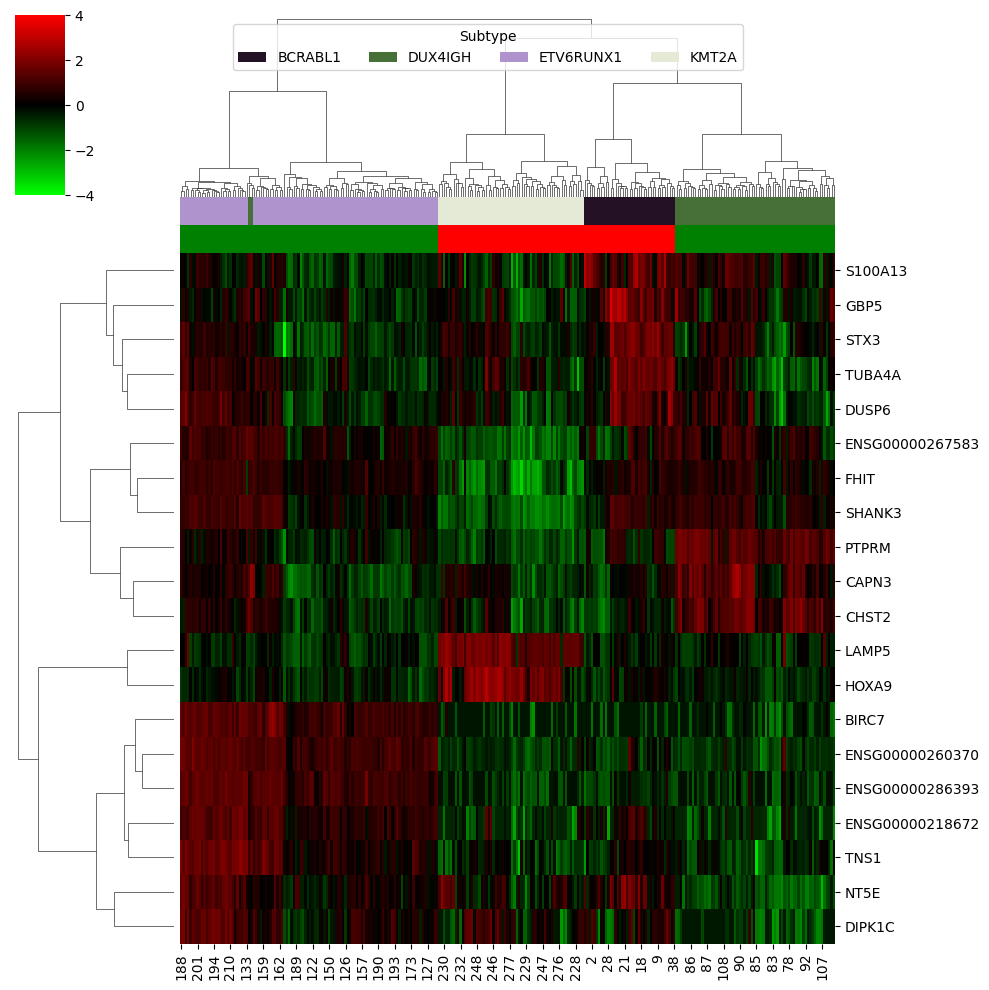

In [ ]:
cluster_data = data.drop(axis=1, labels=["prognostic", "subtype"])[important_genes].transpose()

subtypes = data["subtype"]
palette = sns.cubehelix_palette(subtypes.unique().size, light=.9, dark=.1, reverse=True, start=1, rot=-2)
lut = dict(zip(map(str, subtypes.unique()), palette))
col_colors = [subtypes.map(lut), data["prognostic"].map({ "POOR": "r", "GOOD": "g" })]

g = plot_clustermap(cluster_data, col_colors)
plot_legend(g, subtypes, lut)

plt.show()

In [ ]:
model, score, feature_names = train_forest(target="subtype", data=data[["prognostic", "subtype", *important_genes]])
print(f"F1 Score: {score}")

Acc: 0.9479166666666666
F1 Score: 0.9566254679298158


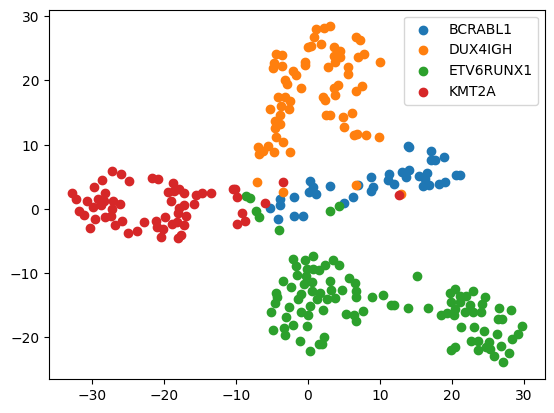

In [ ]:
tsne = TSNE(n_components=2, random_state=42, perplexity=18, n_jobs=16, early_exaggeration=20, n_iter=5000).fit_transform(data.drop(axis=1, labels=["prognostic", "subtype"])[important_genes])
fig, ax = plt.subplots()

groups = pd.DataFrame(tsne, columns=["x", "y"]).assign(category=data["subtype"]).groupby("category")
for name, points in groups:
    ax.scatter(points.x, points.y, label=name)

ax.legend()

5 6


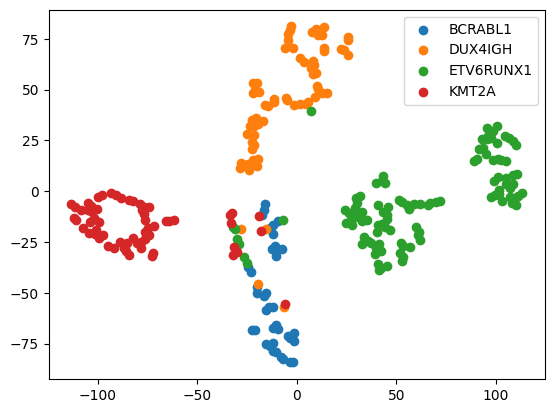

5 12


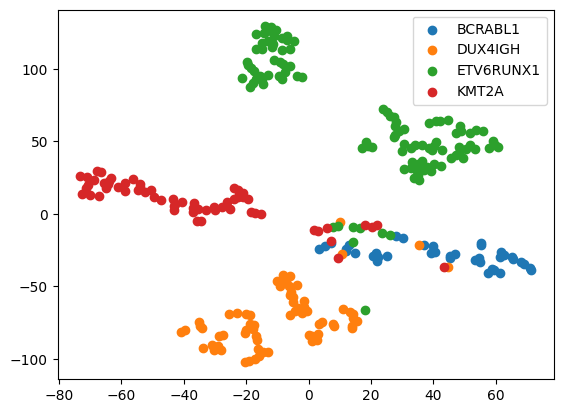

5 20


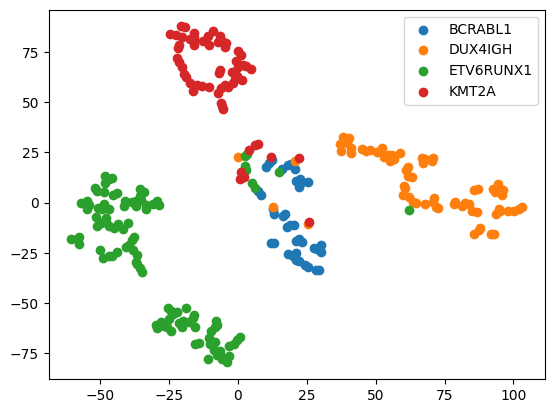

5 25


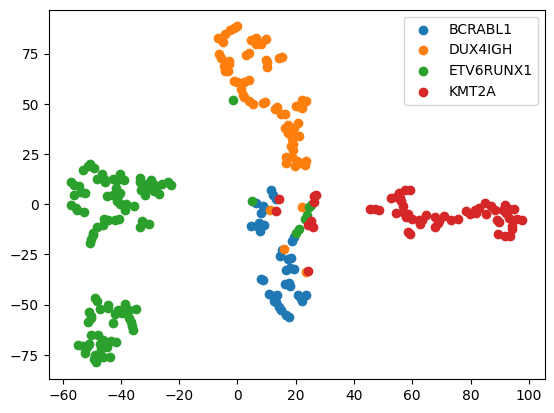

5 50


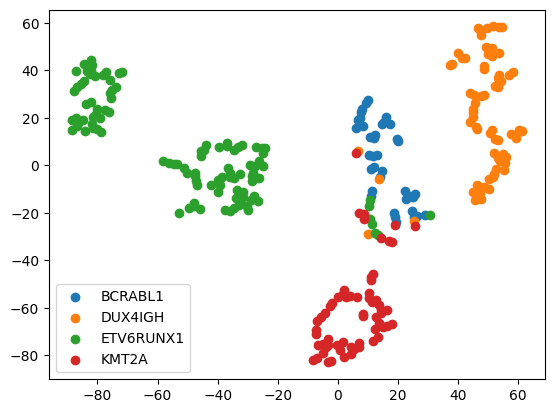

5 75


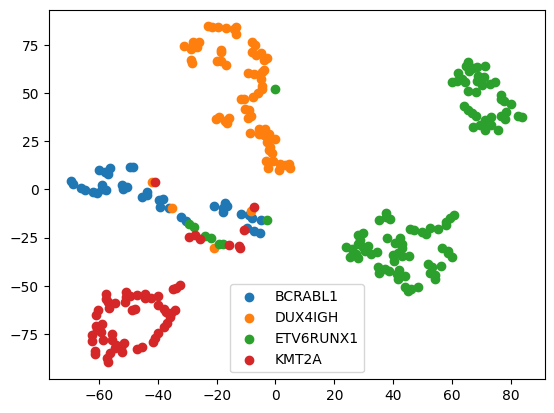

10 6


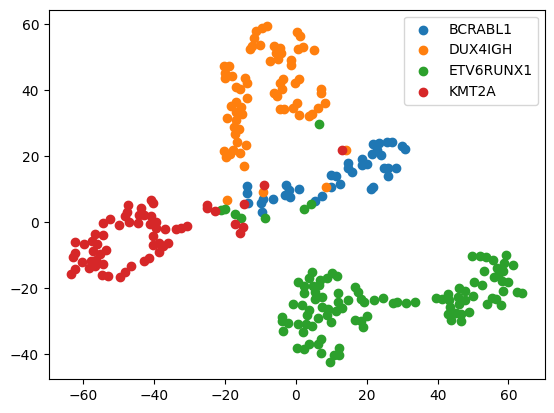

10 12


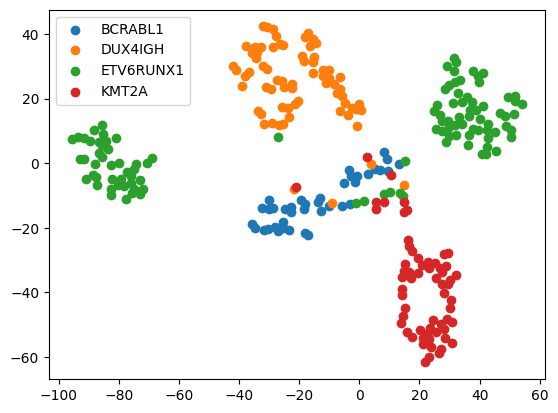

10 20


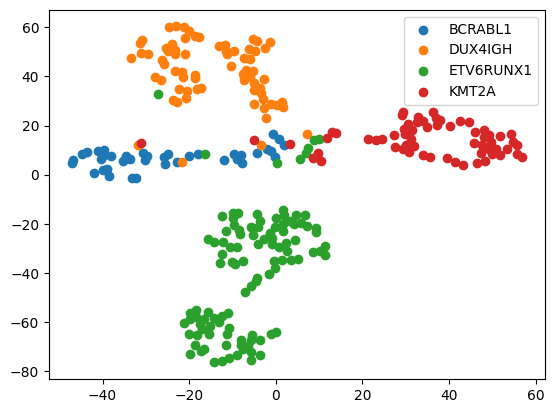

10 25


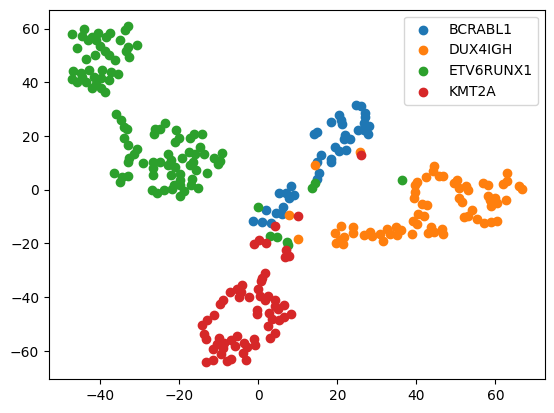

10 50


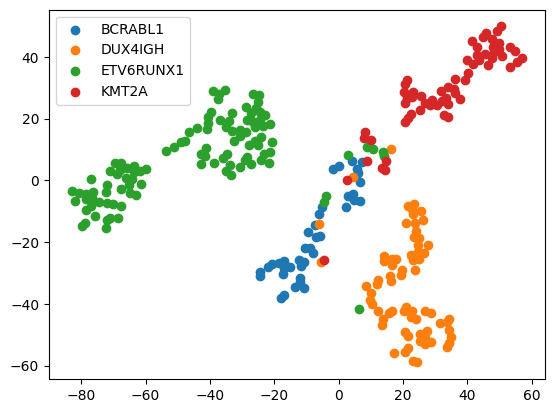

10 75


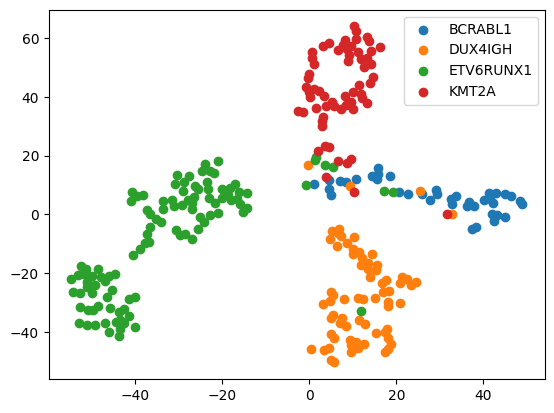

12 6


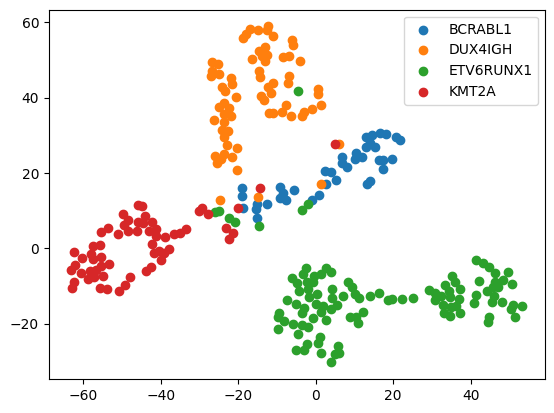

12 12


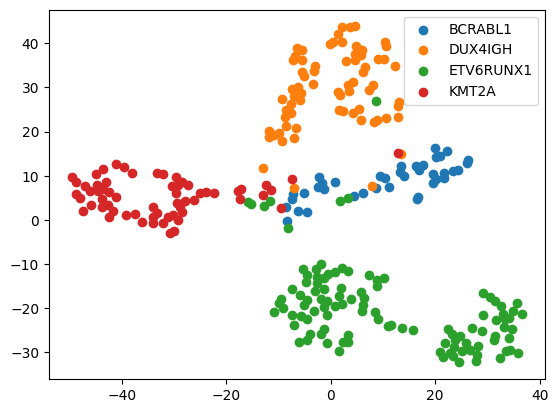

12 20


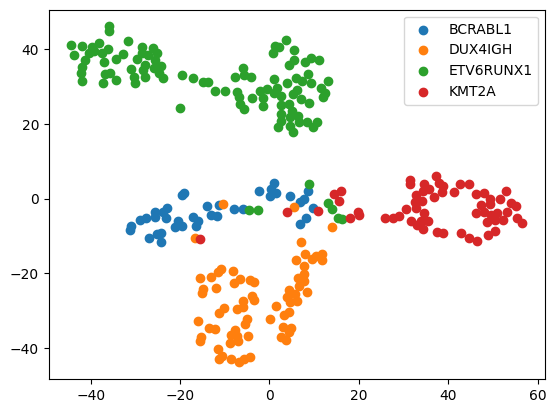

12 25


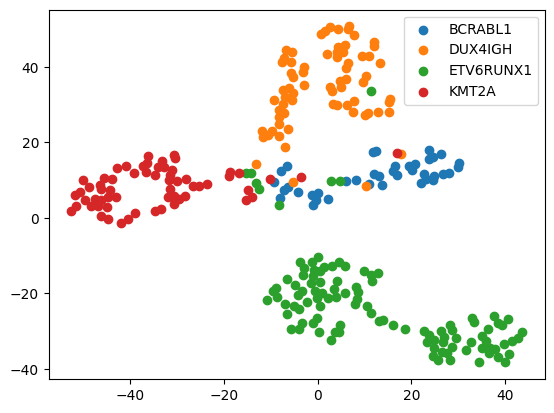

12 50


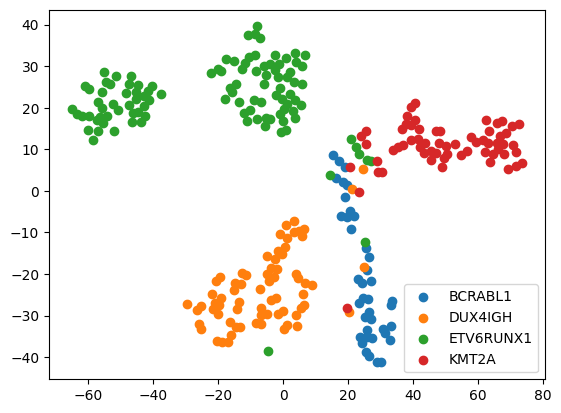

12 75


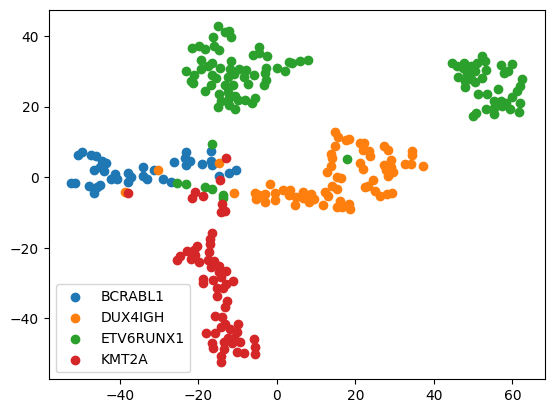

15 6


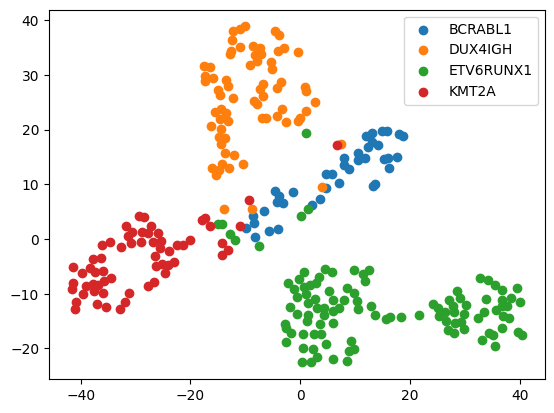

15 12


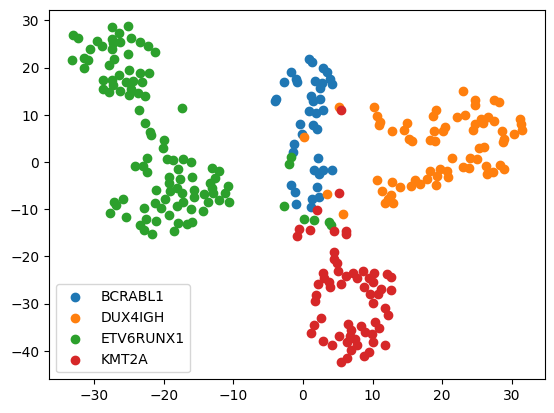

15 20


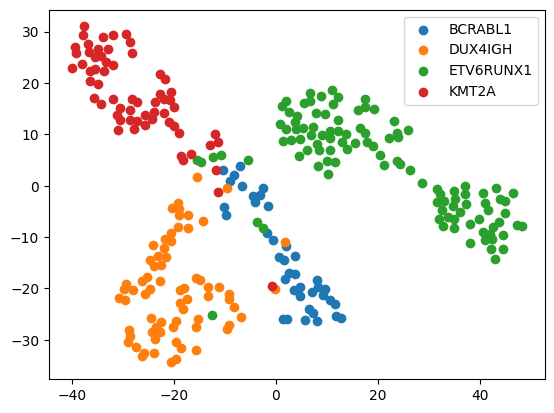

15 25


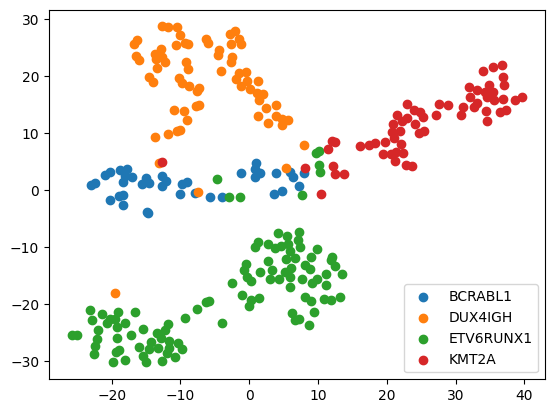

15 50


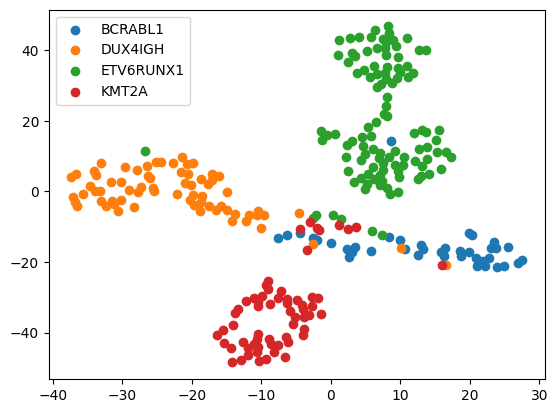

15 75


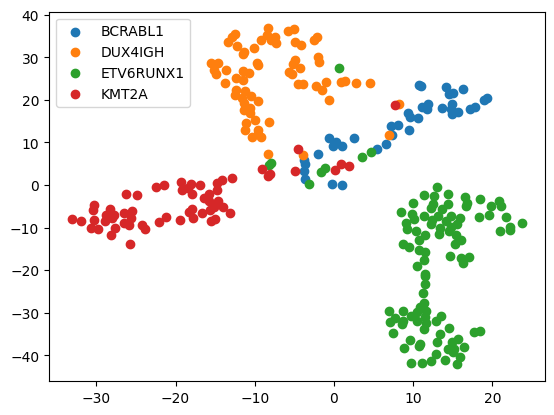

18 6


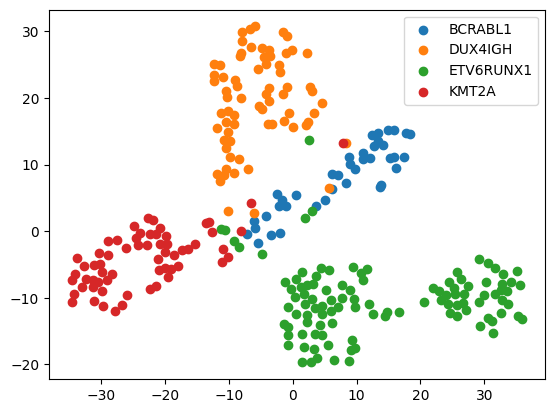

18 12


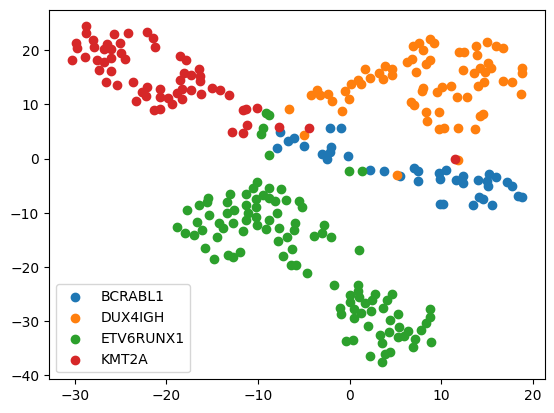

18 20


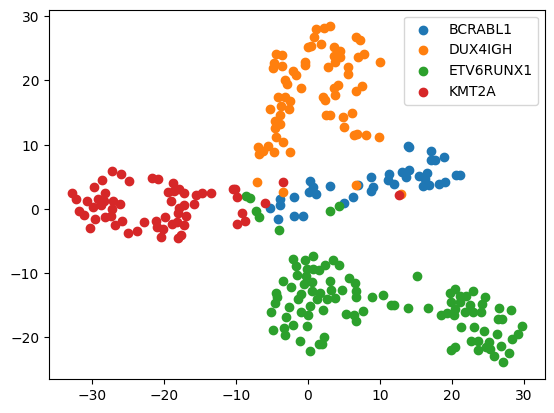

18 25


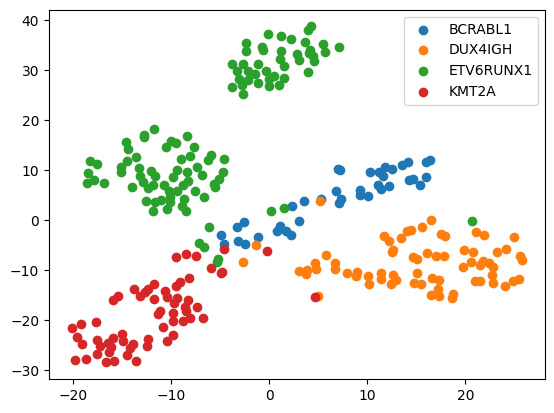

18 50


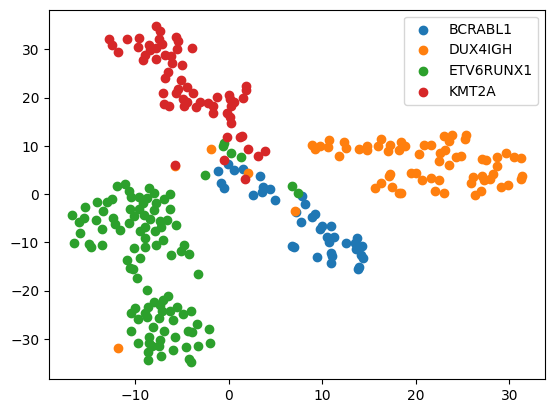

18 75


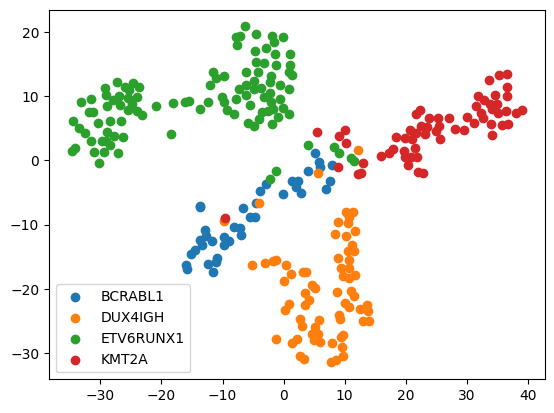

20 6


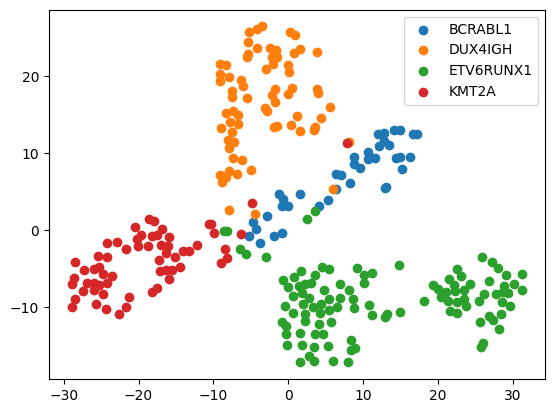

20 12


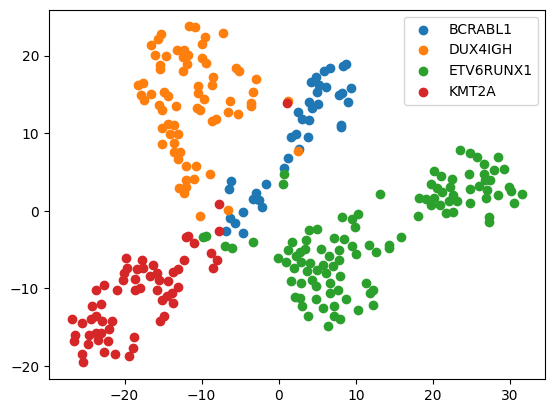

20 20


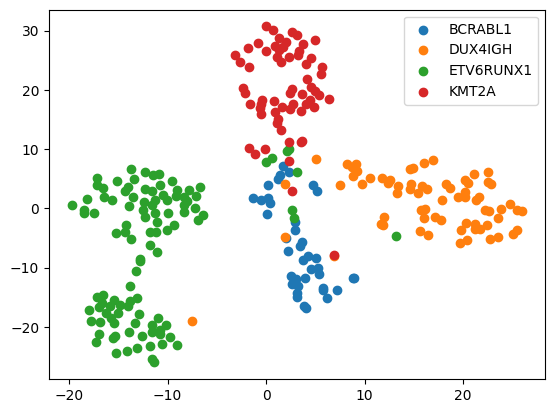

20 25


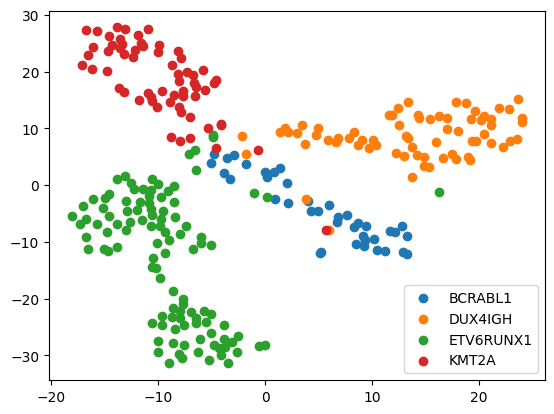

20 50


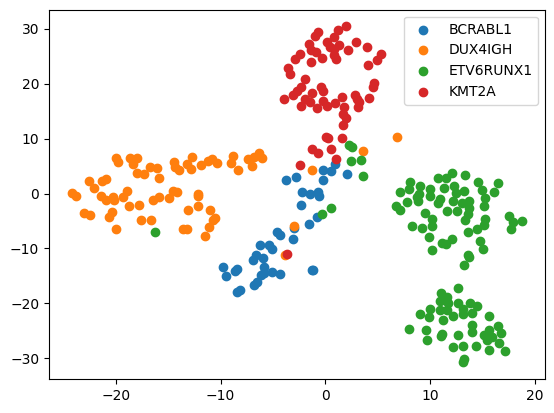

20 75


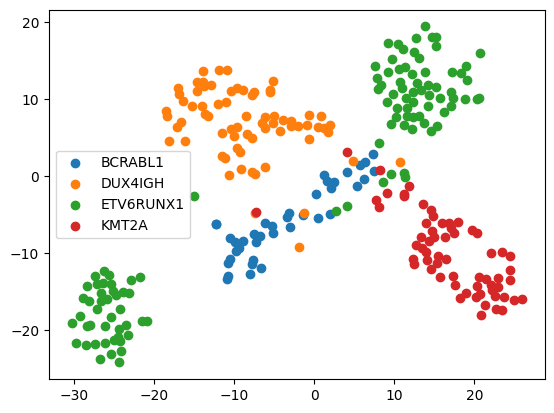

25 6


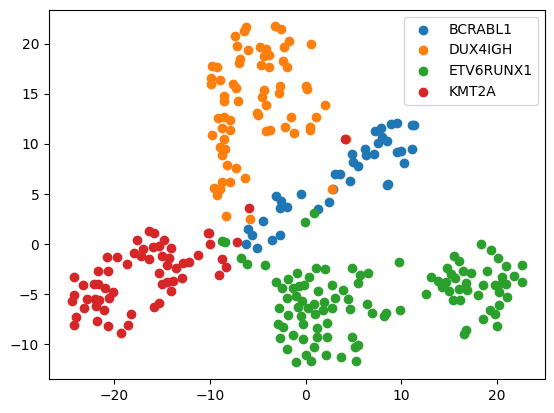

25 12


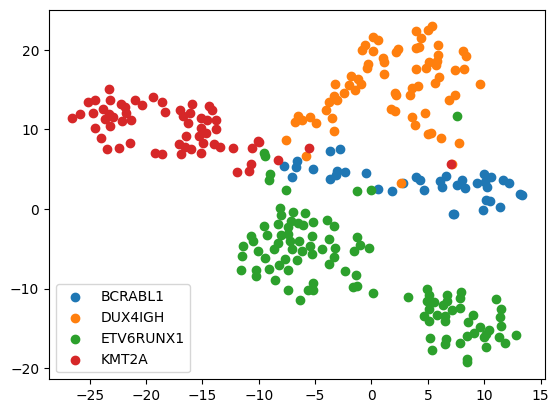

25 20


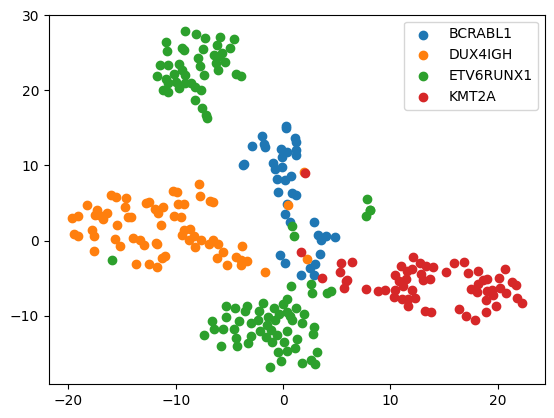

25 25


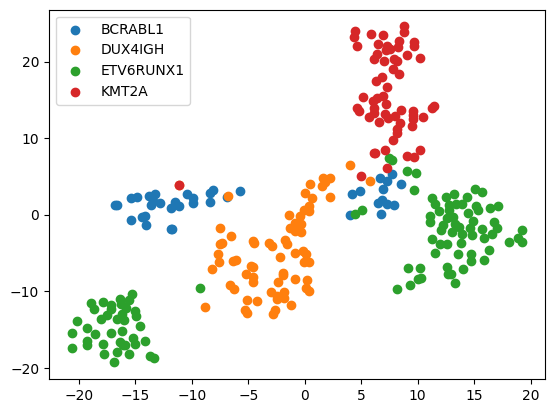

25 50


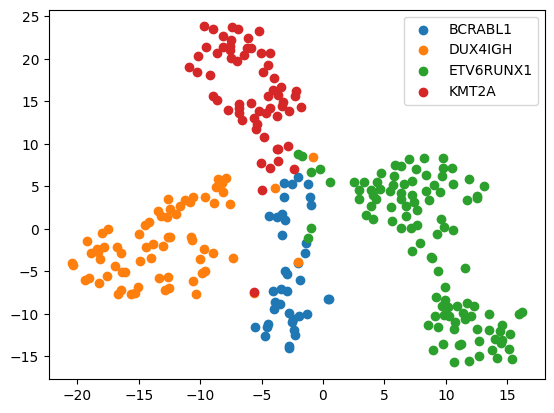

25 75


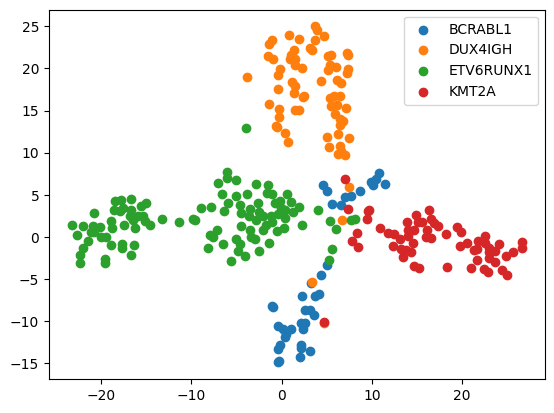

30 6


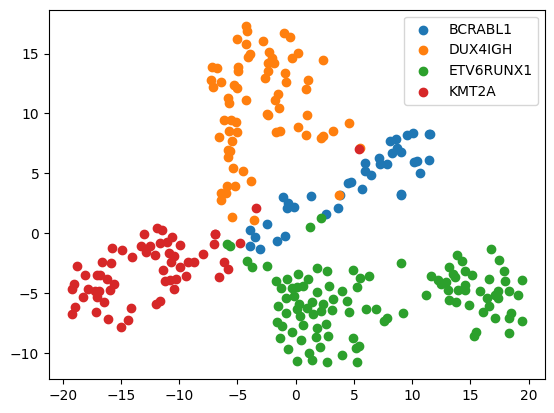

30 12


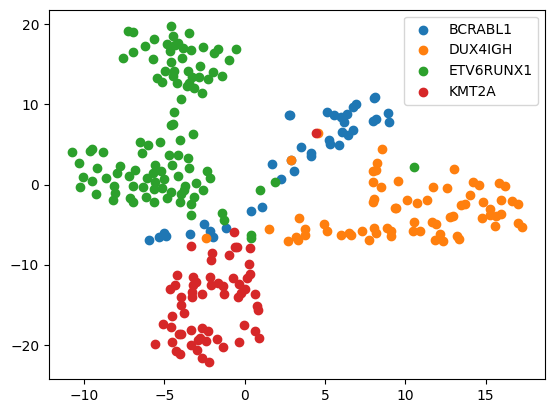

30 20


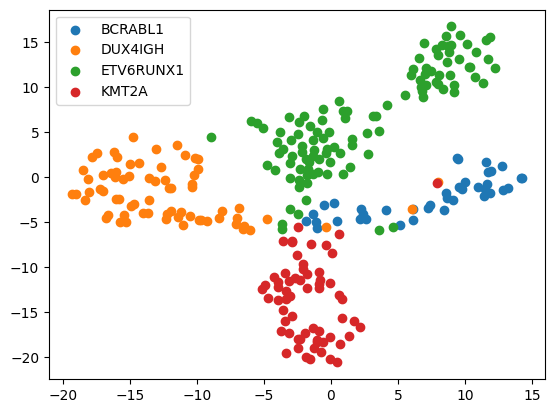

30 25


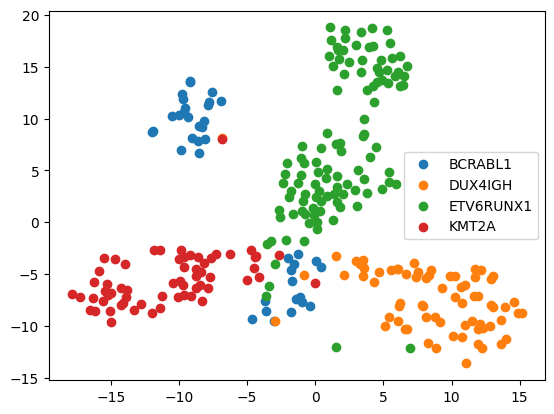

30 50


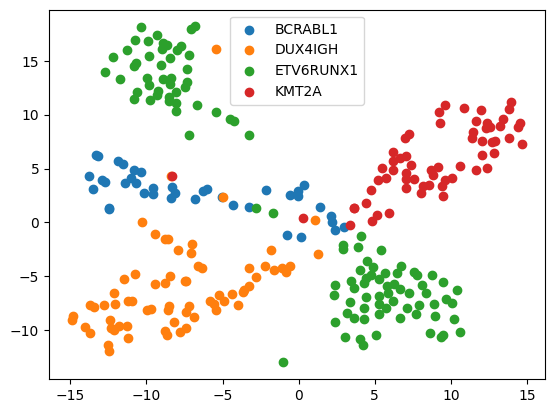

30 75


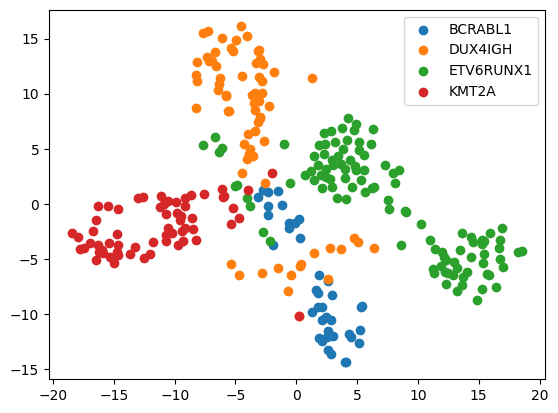

35 6


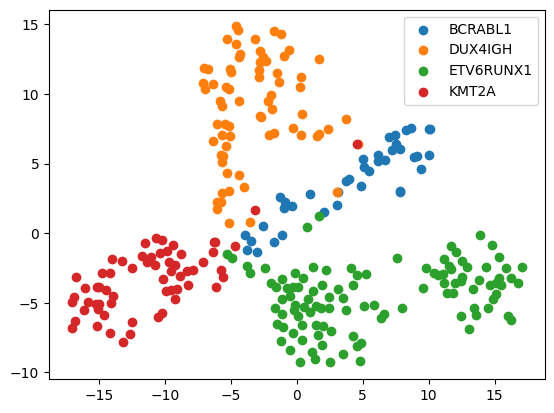

35 12


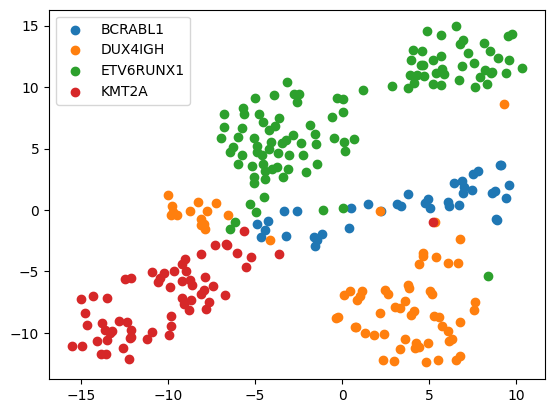

35 20


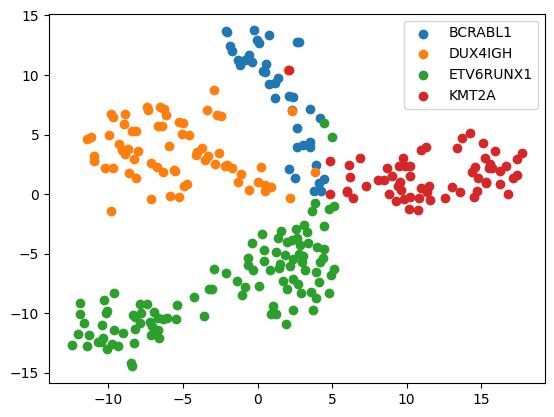

35 25


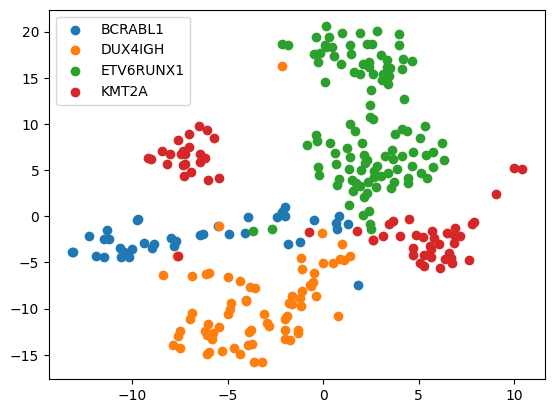

35 50


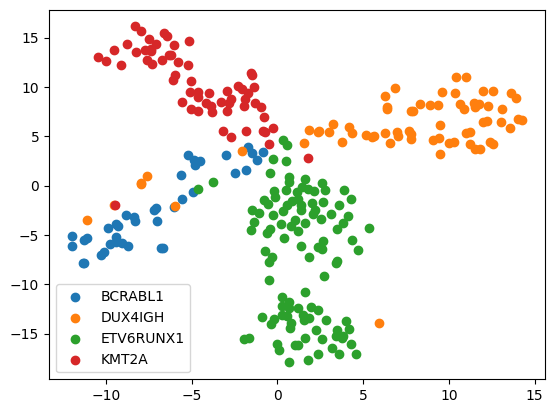

35 75


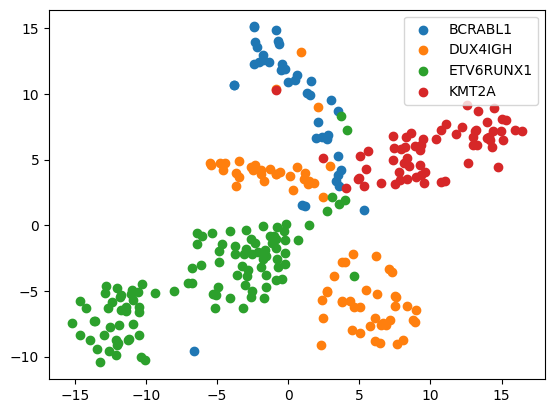

40 6


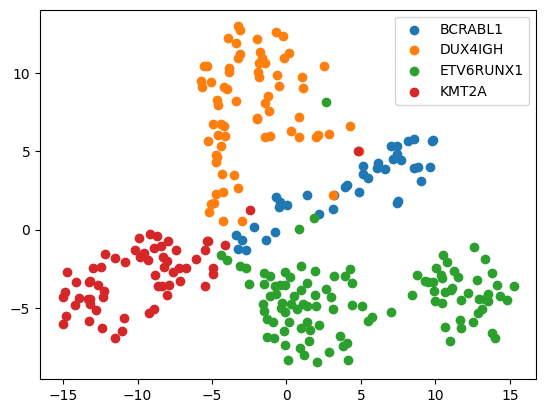

40 12


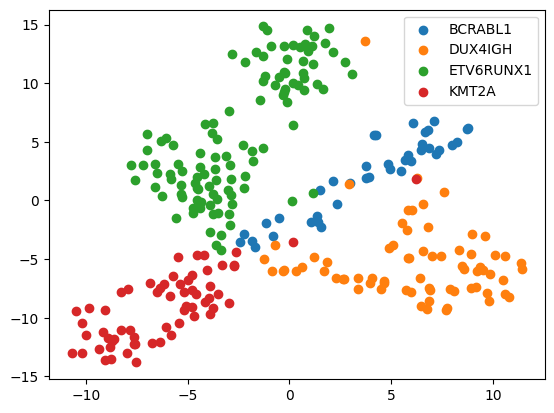

40 20


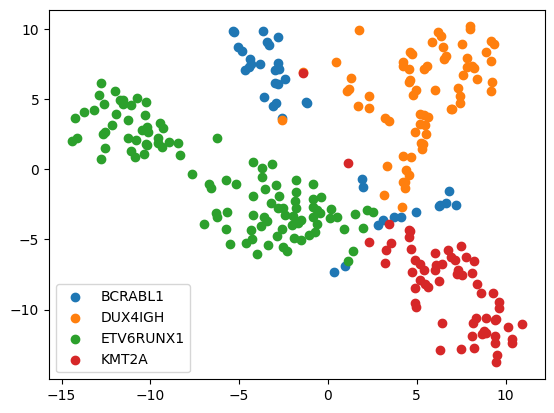

40 25


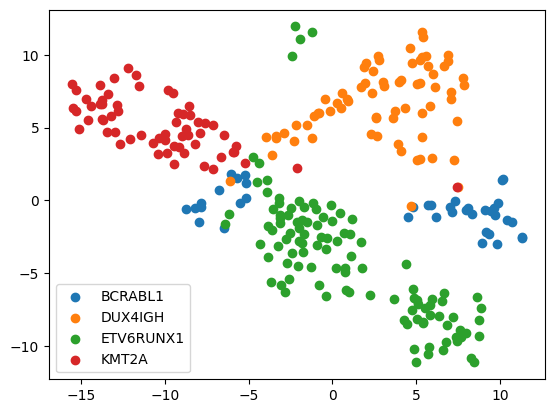

40 50


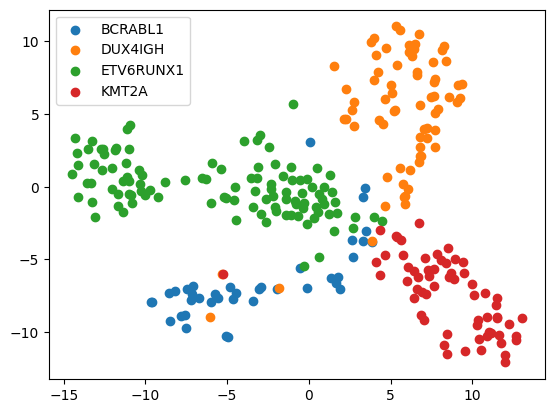

40 75


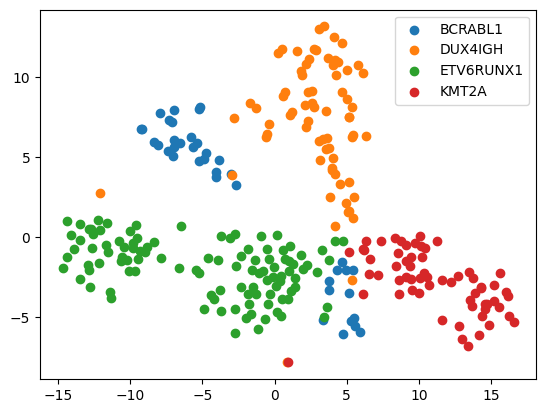

50 6


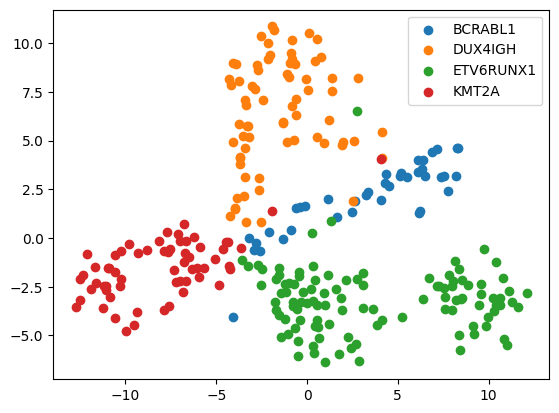

50 12


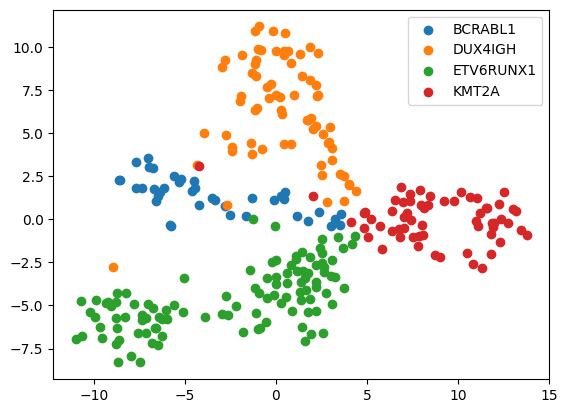

50 20


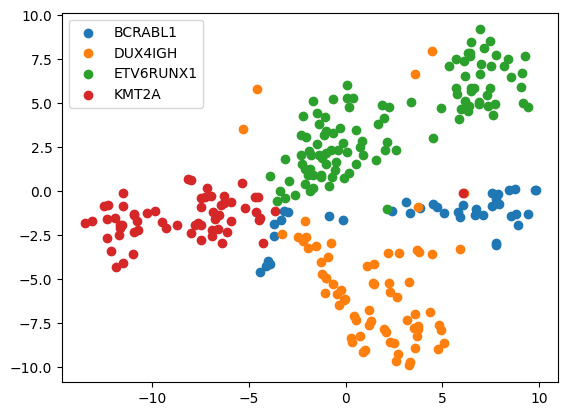

50 25


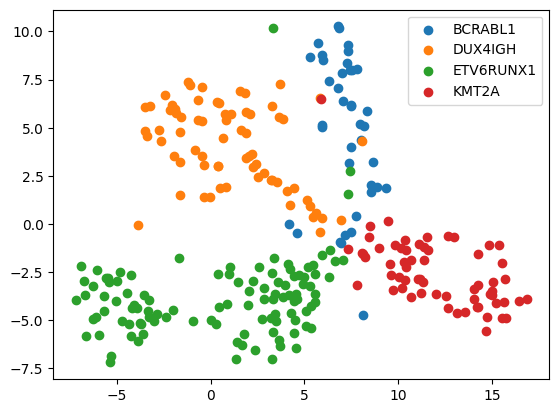

50 50


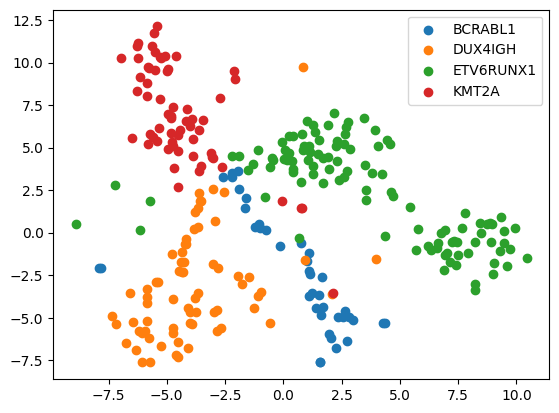

50 75


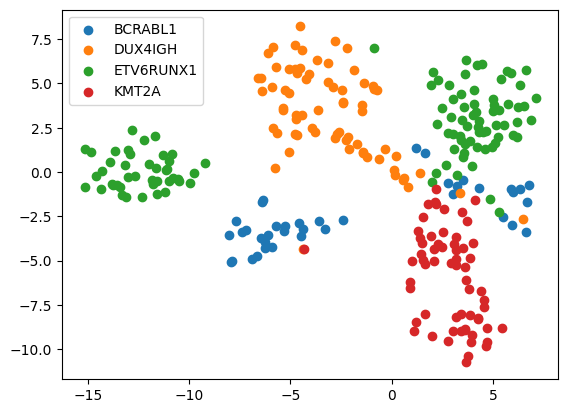

In [ ]:
for x in [5, 10, 12, 15, 18, 20, 25, 30, 35, 40, 50]:
  for y in [6, 12, 20, 25, 50, 75]:
    print(f"{x} {y}")
    tsne = TSNE(n_components=2, random_state=42, perplexity=x, n_jobs=16, early_exaggeration=y, n_iter=5000).fit_transform(data.drop(axis=1, labels=["prognostic", "subtype"])[important_genes])
    fig, ax = plt.subplots()

    groups = pd.DataFrame(tsne, columns=["x", "y"]).assign(category=data["subtype"]).groupby("category")
    for name, points in groups:
        ax.scatter(points.x, points.y, label=name)

    ax.legend()
    plt.show()

In [ ]:
import dotenv
import os
import stringdb
import json
from neo4j import GraphDatabase

load_status = dotenv.load_dotenv("/content/drive/MyDrive/neo4j.env")
if load_status is False:
    raise RuntimeError('Environment variables not loaded.')

URI = os.getenv("NEO4J_URI")
AUTH = (os.getenv("NEO4J_USERNAME"), os.getenv("NEO4J_PASSWORD"))

BASE_URL_EXTERNAL = "https://raw.githubusercontent.com/mc936-2024/datasci4health/main/project3-final/data/external"
BASE_URL_INTERIM = "https://raw.githubusercontent.com/mc936-2024/datasci4health/main/project3-final/data/interim"
FILES = ["analyzed_genes", "jak_stat_pathway", "pi3k_pathway", "rtk_ras_pathway"]

with GraphDatabase.driver(URI, auth=AUTH) as driver:
    driver.verify_connectivity()
    print("Driver connected, creating resources")

    cleanup = input("Cleanup environment before proceeding? (Y/n)") != "n"
    if cleanup:
      driver.execute_query("MATCH ()-[e]-() DELETE e")
      driver.execute_query("MATCH (n) DELETE n")
      print("Environment cleaned up!")

    # print("Creating nodes...")
    # for file in FILES:
    #   driver.execute_query(f"""
    #     LOAD CSV WITH HEADERS FROM '{BASE_URL_EXTERNAL}/{file}_nodes.tsv'
    #     AS row FIELDTERMINATOR '\t'
    #     MERGE (:Gene {{name: row['#node'], id: row['identifier']}})
    #   """)

    print("Creating edges...")
    for file in FILES:
      driver.execute_query(f"""
        LOAD CSV WITH HEADERS FROM '{BASE_URL_EXTERNAL}/{file}_edges.tsv'
        AS row FIELDTERMINATOR '\t'
        MERGE (g1:Gene {{name: row['#node1'], id: row['node1_string_id']}})
        MERGE (g2:Gene {{name: row['node2'], id: row['node2_string_id']}})
        MERGE (g1)-[:Interacts {{score: row['combined_score']}}]->(g2)
      """)

    print("Adding top importance gene interactions...")
    next_level = set()
    for index, row in stringdb.get_interaction_partners(important_genes).iterrows():
      if row["escore"] < 0.4 and row["dscore"] < 0.4:
        continue

      driver.execute_query(f"""
        MERGE (g1:Gene {{name: "{row["preferredName_A"]}", id: "{row["stringId_A"]}"}})
        MERGE (g2:Gene {{name: "{row["preferredName_B"]}", id: "{row["stringId_B"]}"}})
        MERGE (g1)-[:Interacts {{score: {row["score"]}}}]->(g2)
      """)

      next_level.add(row["preferredName_A"])
      next_level.add(row["preferredName_B"])

    # next_level -= set(important_genes)
    # for index, row in stringdb.get_interaction_partners(list(next_level)).iterrows():
    #   if row["escore"] < 0.4 and row["dscore"] < 0.4:
    #     continue

    #   driver.execute_query(f"""
    #     MERGE (g1:Gene {{name: "{row["preferredName_A"]}", id: "{row["stringId_A"]}"}})
    #     MERGE (g2:Gene {{name: "{row["preferredName_B"]}", id: "{row["stringId_B"]}"}})
    #     MERGE (g1)-[:Interacts {{score: {row["score"]}}}]->(g2)
    #   """)

    print("Updating important genes...")
    for gene in important_genes:
      driver.execute_query(f"""
        MATCH (g:Gene {{id: "{gene}"}})
        SET g.important = true
      """)

    driver.execute_query(f"""
      LOAD CSV WITH HEADERS FROM '{BASE_URL_INTERIM}/drugs.tsv'
      AS row FIELDTERMINATOR '\t'
      MERGE (:Drug {{name: row['name'], abbreviation: row['abbreviation']}})
    """)

    drugs = pd.read_csv(f"{BASE_URL_INTERIM}/drugs.tsv", sep="\t")
    for index, row in drugs.iterrows():
      drug_name = row["name"]
      for activate in json.loads(row["antagonizes"].replace("'", '"')):
        driver.execute_query(f"""
          MATCH (g:Gene {{name: "{activate}"}})
          MATCH (d:Drug {{name: "{drug_name}"}})
          MERGE (d)-[:Antagonizes]->(g)
        """)

      for inhibit in json.loads(row["inhibits"].replace("'", '"')):
        driver.execute_query(f"""
          MATCH (g:Gene {{name: "{inhibit}"}})
          MATCH (d:Drug {{name: "{drug_name}"}})
          MERGE (d)-[:Inhibits]->(g)
        """)

    print("Database set up!")



Driver connected, creating resources
Cleanup environment before proceeding? (Y/n)Y
Environment cleaned up!
Creating edges...
Adding top importance gene interactions...
Updating important genes...
Database set up!


Adicionar relação de pertencimento dos genes ao subtipo

In [ ]:
import csv

with GraphDatabase.driver(URI, auth=AUTH) as driver:
    distances = {}
    for subtype in importances_by_subtype:
        driver.execute_query(f"""
            MERGE (:Subtype {{name: "{subtype}"}})
        """)
        for gene in importances_by_subtype[subtype].keys():
            driver.execute_query(f"""
                MATCH (s:Subtype {{name: "{subtype}"}})
                MATCH (g:Gene {{name: "{gene}"}})
                MERGE (g)-[:AssociatedWith]->(s)
            """)

        # Calculate distance between each drug and the subtype
        results = driver.execute_query(f"""
            MATCH (d:Drug)
            MATCH (s:Subtype)
            WHERE s.name = "{subtype}"
            RETURN d.name, length(shortestPath((d)-[*1..]-(s)))
        """)

        for i in range(len(results.records)):
            if subtype not in distances:
                distances[subtype] = {}
            distances[subtype][results.records[i].values()[0]] \
                = results.records[i].values()[1]

with open("/content/drive/MyDrive/distances.csv", 'w') as file:
    root = csv.writer(file, delimiter=',')
    first_iter = True
    for subtype in distances:
        if first_iter:
            root.writerow(["Genes"] + list(distances[subtype].keys()))
            first_iter = False
        root.writerow([subtype] + list(distances[subtype].values()))

In [ ]:
distance_csv = pd.read_csv("/content/drive/MyDrive/distances.csv", header=None)

distance_csv

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,Genes,5-Azacytidine,Belinostat,Cladribine,Copanlisib dihydrochloride,Dasatinib,Duvelisib,Fedratinib,Gilteritinib,Idelalisib,Imatinib mesylate,Niraparib,Panobinostat,Ponatinib,Romidepsin,Selinexor (KPT-330),Vincristine (sulfate),Vorinostat (SAHA)
1,BCRABL1,3,2,1,2,2,2,2,3,3,2,3,2,2,2,3,1,2
2,DUX4IGH,2,2,1,2,2,3,3,3,3,2,3,2,2,2,2,3,2
3,ETV6RUNX1,2,2,2,3,3,3,3,3,3,3,2,2,3,3,3,2,2
4,KMT2A,3,2,3,3,2,3,3,3,3,1,3,2,3,2,3,3,2
